### Packages

In [1]:
import pandas as pd
import shap
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import random

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Get data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/SamuelFriedlaender/ML_assignment/master/"
CAR_URL = DOWNLOAD_ROOT + "preprocessed_data_ml.csv"

def fetch_ML_data(car_url=CAR_URL):
    # Download the CSV data directly into a Pandas DataFrame
    car_df = pd.read_csv(car_url)
    return car_df

df = fetch_ML_data()

### Initial data preparation and train/test split

In [3]:
random.seed(42)
variable_names = df.columns[1:].tolist()
df = df.drop(['Unnamed: 0'], axis=1)

# Convert the selected columns to numeric type
df[variable_names] = df[variable_names].apply(pd.to_numeric)

# We use 70/30 train/test split
X = df.drop(['Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Function for displaying the scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Model 1: Linear Regression

In [4]:
Linreg = LinearRegression()
Linreg.fit(np.array(X_train), y_train)

# Test the model on new data
y_pred = Linreg.predict(np.array(X_test))
print('R2:', r2_score(y_test, y_pred))
print('Linear Regression RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Linear Regression MAE:', mean_absolute_error(y_test, y_pred))

# Backward stepwise selection
X_tmp = sm.add_constant(X_train)
est = sm.OLS(y_train, X_tmp)
est = est.fit()
print(est.summary())

R2: 0.4239488178624057
Linear Regression RMSE: 8435.142393182254
Linear Regression MAE: 6445.00724946188
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     347.5
Date:                Mon, 20 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:51:48   Log-Likelihood:            -1.0440e+05
No. Observations:                9993   AIC:                         2.089e+05
Df Residuals:                    9969   BIC:                         2.090e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------

#### Cross-validation of Linear Regression (RMSE)

In [5]:
lin_scores = cross_val_score(Linreg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-lin_scores)

Scores: [8359.32864803 8088.83914986 8417.19330053 8077.13447256 7904.85490469
 8539.81657038 8544.46546707 8358.41028968 8602.73238823 8612.51267934]
Mean: 8350.528787036379
Standard deviation: 234.97198915110377


#### Cross-validation of Linear Regression (MAE)

In [6]:
lin_scores = cross_val_score(Linreg, X_train, y_train, scoring="neg_mean_absolute_error", cv=10)
display_scores(-lin_scores)

Scores: [6357.19185729 6216.76336869 6439.65162759 6181.75899627 5994.73962306
 6710.69027375 6607.31491345 6421.82077419 6472.67131033 6511.45710114]
Mean: 6391.405984575338
Standard deviation: 201.44350572408126


# Model 2: Decision Tree

In [7]:
#Run default decision tree  (max_depth=None, min_samples_split=2, min_samples_leaf=1)

tree_reg = DecisionTreeRegressor(random_state = 42)

tree_reg.fit(X_train, y_train)

tree_predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_predictions)
tree_mae = mean_absolute_error(y_test, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Decision Tree RMSE:', tree_rmse)
print('Decision Tree MAE:', tree_mae)

Decision Tree RMSE: 7768.566886794119
Decision Tree MAE: 4658.046945330267


#### Cross-validation before Hyperparameter Tuning

##### RMSE

In [8]:
scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores)

Scores: [7649.03561563 7724.49063037 7570.93845094 7620.86779876 7388.11135818
 8315.65753652 8166.34014616 7806.55040496 8207.18016897 8118.31288512]
Mean: 7856.748499561535
Standard deviation: 302.9467393060539


##### MAE

In [9]:
scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=10)
display_scores(-scores)

Scores: [4501.43634821 4749.11506421 4448.82411784 4531.69749901 4527.67303624
 4966.96672993 4982.51529367 4738.40562633 4862.4844574  4776.34997333]
Mean: 4708.546814618735
Standard deviation: 186.28274383415933


#### Hyperparameter Tuning for Decision Tree

In [10]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Decision Tree RMSE after HT:', rmse)

Decision Tree RMSE after HT: 7290.507899122185


#### Cross-validation after Hyperparameter Tuning

##### RMSE

In [11]:
scores = cross_val_score(best_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores)

Scores: [6901.46602028 6837.6841663  6658.32695058 6613.86344782 6445.73884419
 7759.01820409 6925.38292896 6801.14830724 7285.87215907 7263.40576747]
Mean: 6949.190679599645
Standard deviation: 368.18618522666355


##### MAE

In [12]:
scores = cross_val_score(best_model, X_train, y_train, scoring="neg_mean_absolute_error", cv=10)
display_scores(-scores)

Scores: [4397.957851   4564.99201382 4467.08104622 4308.03686094 4344.72096396
 4960.55346735 4561.36246816 4499.70648032 4662.87115754 4809.50747248]
Mean: 4557.678978177286
Standard deviation: 195.34836178657417


#### Graphing the best Decision Tree model

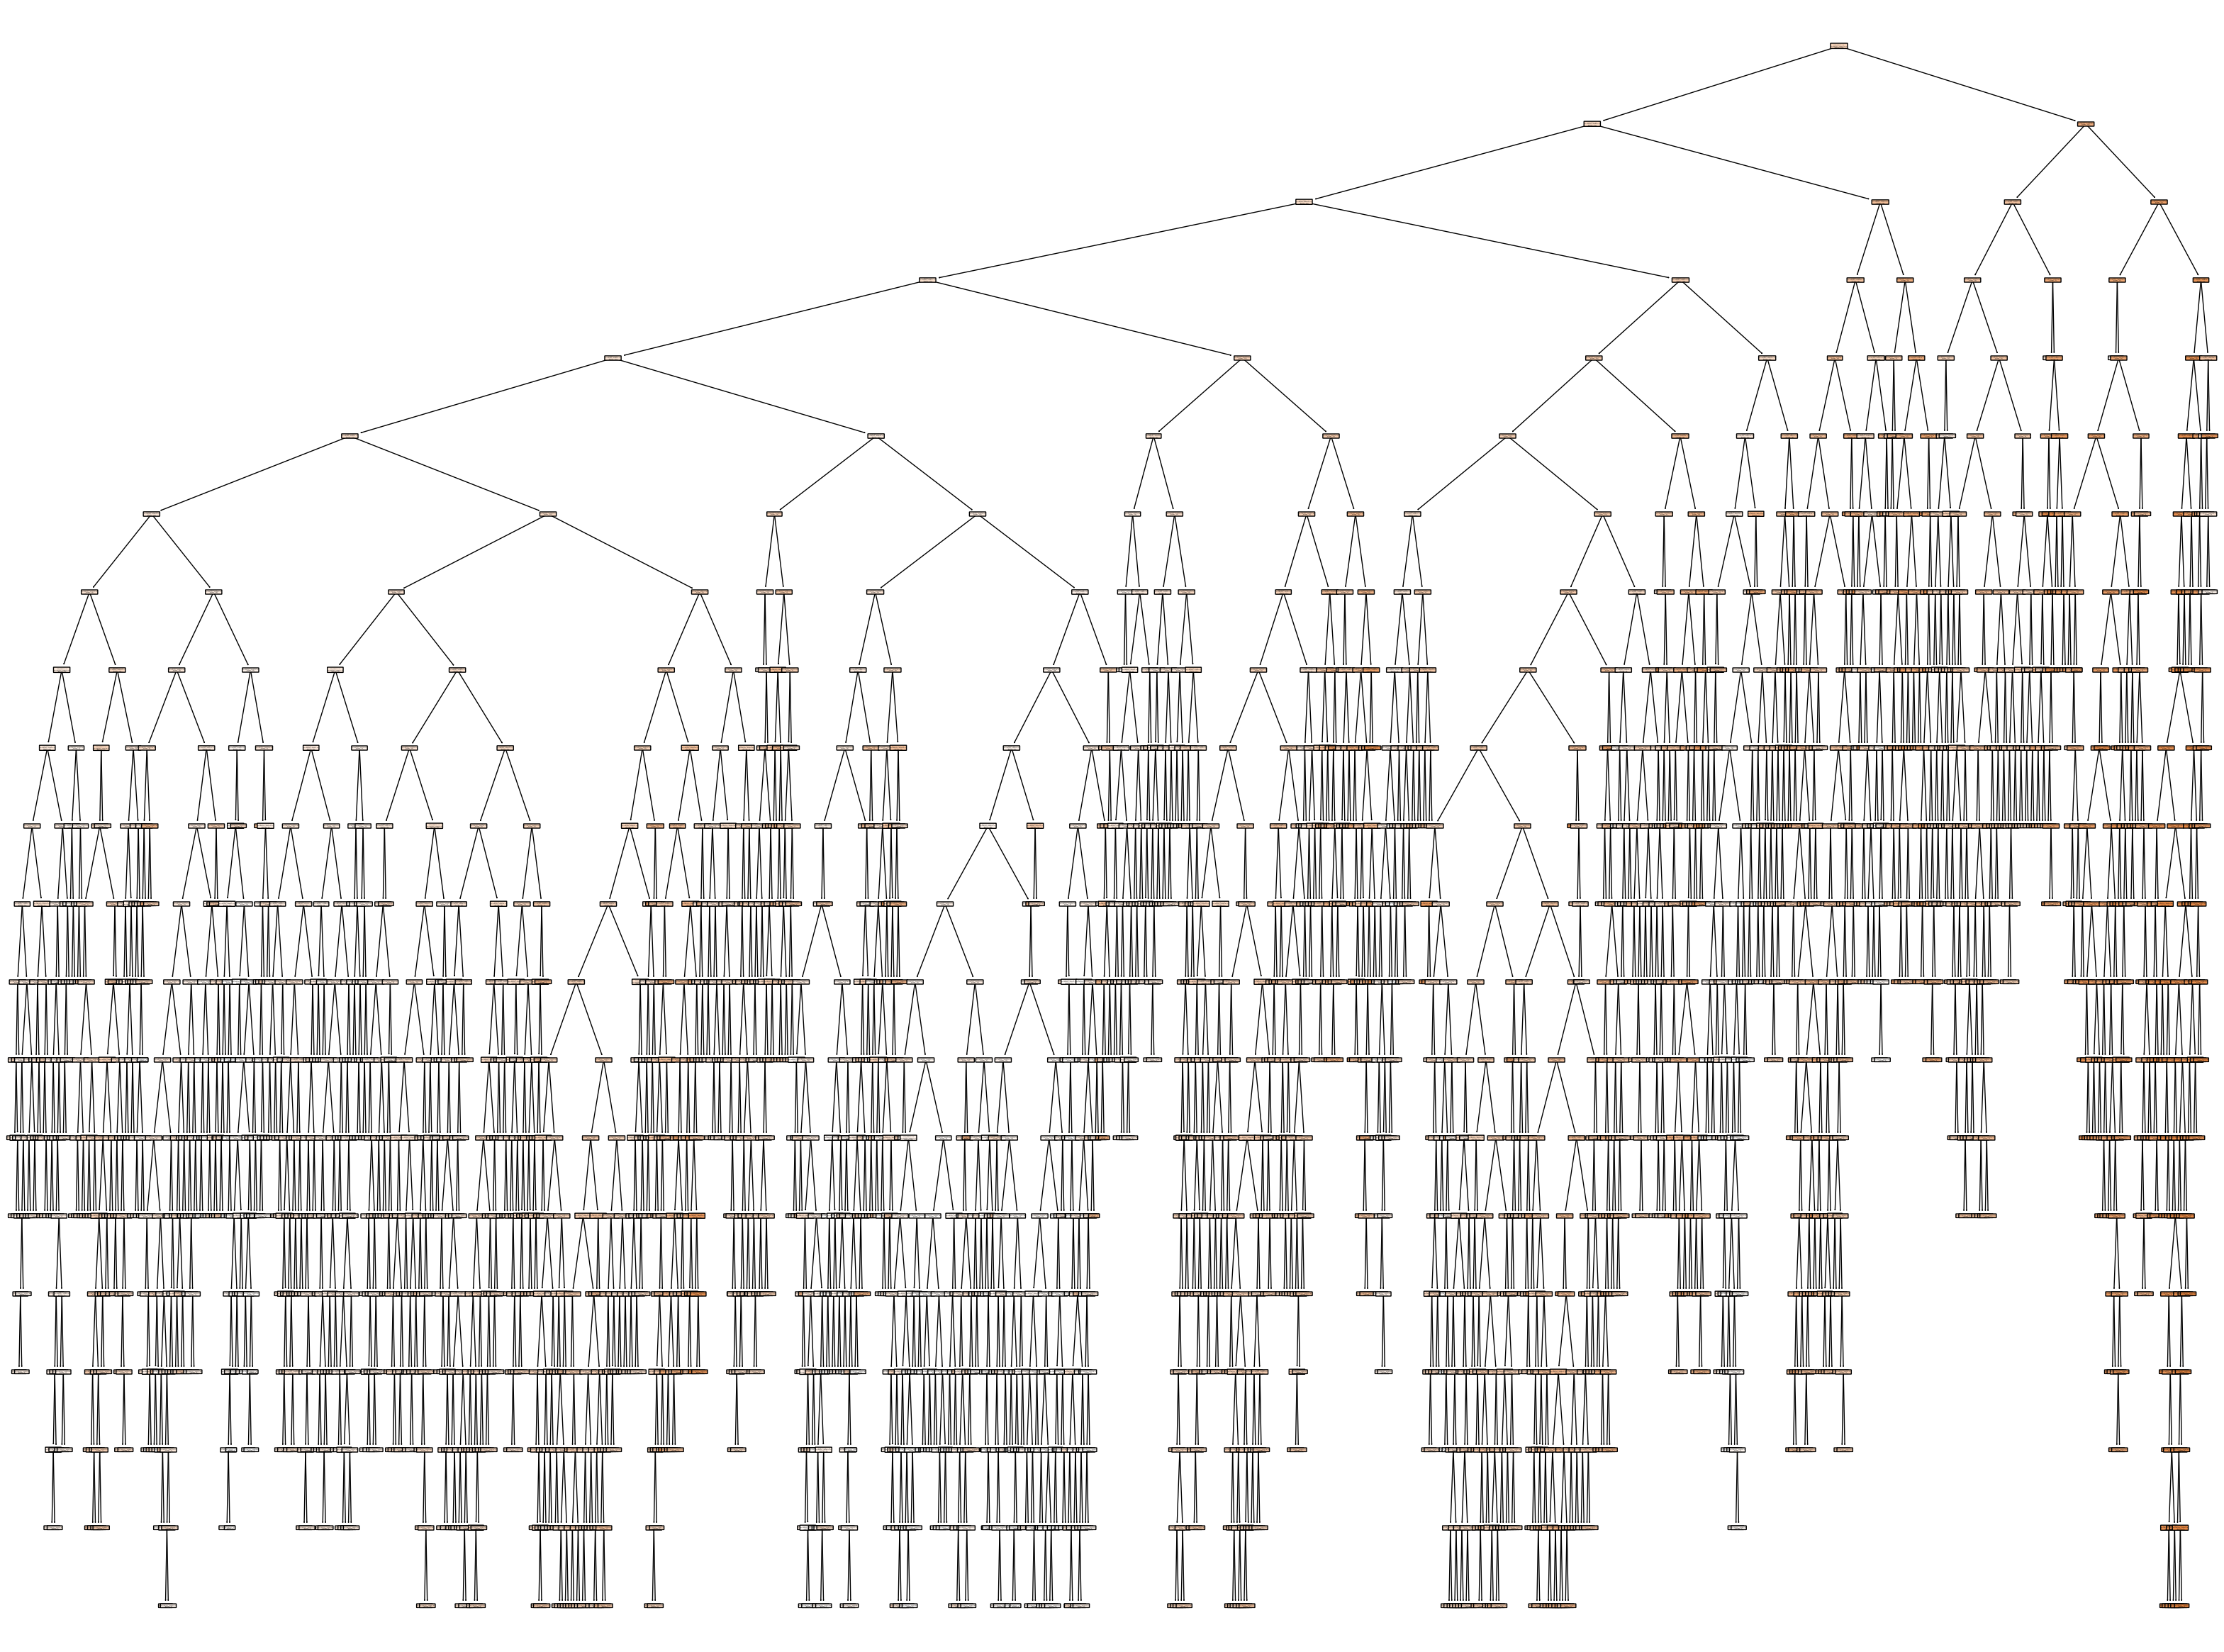

In [13]:
plt.figure(figsize=(40,30)) 
plot_tree(best_model, 
          feature_names=X_train.columns.to_list(), 
          filled=True, 
          rounded=True)
plt.show()

# Model 3: Neural Network

In [14]:
network = MLPRegressor(hidden_layer_sizes=(15, 15), max_iter=7000, early_stopping=True, random_state=42)

network.feature_names_in_ = X_train.columns

network.fit(X_train.values, y_train.values)
y_pred = network.predict(X_test.values)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Neural Network RMSE:', rmse)
print('Neural Network MAE:', mae)

Neural Network RMSE: 8714.96901017606
Neural Network MAE: 6622.079553363819


#### Cross-validation of Neural Network before Hyperparameter Tuning

##### RMSE

In [15]:
NN_scores = cross_val_score(network, X_train.values, y_train.values, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-NN_scores)

Scores: [ 8614.93126991 11086.77336403 11302.42884606  8564.77411149
  8277.12165454  8718.62015218  8866.99824897  8847.24638031
  9088.1738721   9168.62112251]
Mean: 9253.568902209223
Standard deviation: 1001.4733073408759


##### MAE

In [16]:
NN_scores = cross_val_score(network, X_train.values, y_train.values, scoring="neg_mean_absolute_error", cv=10)
display_scores(-NN_scores)

Training interrupted by user.
Training interrupted by user.


Scores: [8229.38226997 8700.786716   8947.71001244 6909.45245937 6284.40049482
 6761.56780478 6853.73088003 6805.67125812 6912.47169821 7023.4080261 ]
Mean: 7342.858161983386
Standard deviation: 875.5919251868384


#### Hyperparameter Tuning for Neural Network

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(5,5), (15,15), (30,30), (50, 50), (100, 100)],
    'learning_rate_init': [0.0001, 0.001, 0.01],
}

mlp = MLPRegressor(max_iter=7000, early_stopping=True, random_state=42)

mlp_cv = GridSearchCV(mlp, param_grid, scoring='neg_root_mean_squared_error', cv=8, n_jobs=-1)

mlp_cv.fit(X_train.values, y_train.values)

GridSearchCV(cv=8,
             estimator=MLPRegressor(early_stopping=True, max_iter=7000,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5, 5), (15, 15), (30, 30),
                                                (50, 50), (100, 100)],
                         'learning_rate_init': [0.0001, 0.001, 0.01]},
             scoring='neg_root_mean_squared_error')

In [ ]:
best_params = mlp_cv.best_params_

best_mlp = MLPRegressor(**best_params, max_iter=7000, random_state=42, early_stopping=True)
best_mlp.fit(X_train.values, y_train.values)

y_pred = best_mlp.predict(X_test.values)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Neural Network RMSE after HT:', rmse)
print('Neural Network MAE after HT:', mae)

Neural Network RMSE after HT: 8660.76775126262
Neural Network MAE after HT: 6568.443151775852


#### Cross-validation of Neural Network after Hyperparameter Tuning

##### RMSE

In [ ]:
NN_scores = cross_val_score(best_mlp, X_train.values, y_train.values, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-NN_scores)

Scores: [8452.96765841 8206.71340817 8653.67511503 8467.03705044 8208.28873732
 8596.97304363 8709.46940253 8623.34761618 8826.37141272 8943.97952475]
Mean: 8568.88229691795
Standard deviation: 228.62881910508878


##### MAE

In [ ]:
NN_scores = cross_val_score(best_mlp, X_train.values, y_train.values, scoring="neg_mean_absolute_error", cv=10)
display_scores(-NN_scores)

Scores: [6348.83566439 6231.8875704  6522.47915695 6474.73691084 6199.27762493
 6640.04954398 6658.444538   6564.86855626 6563.51298651 6784.67920119]
Mean: 6498.877175346266
Standard deviation: 178.96994998751023


#### Shapley Values for Neural Network interpretation

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4284 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


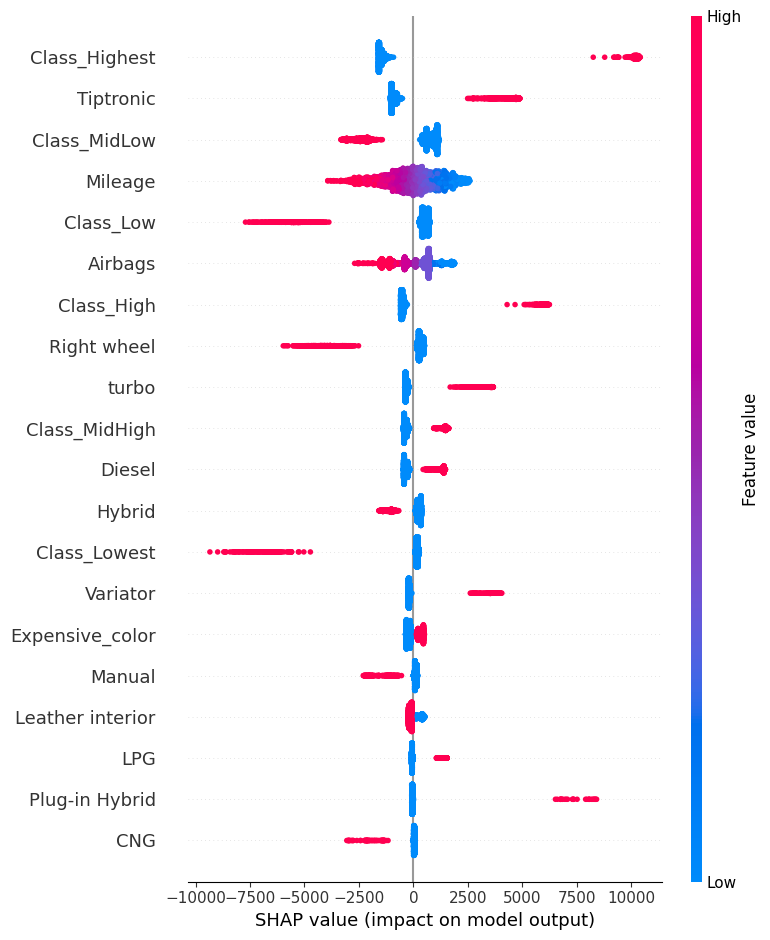

In [ ]:
K = 500

# Create a summary dataset using shap.sample()
summary_data = shap.sample(X_train, K)
explainer = shap.KernelExplainer(best_mlp.predict,summary_data)
shap_values = explainer.shap_values(X_test, nsamples=1000)
shap.summary_plot(shap_values, X_test)